Epoch 1/100
36/36 [==============================] - 14s 153ms/step - loss: 0.4782 - val_loss: 0.0015
Epoch 2/100
36/36 [==============================] - 4s 100ms/step - loss: 0.2388 - val_loss: 4.4302e-05
Epoch 3/100
36/36 [==============================] - 4s 112ms/step - loss: 0.2236 - val_loss: 6.0866e-05
Epoch 4/100
36/36 [==============================] - 4s 102ms/step - loss: 0.2157 - val_loss: 2.2786e-05
Epoch 5/100
36/36 [==============================] - 4s 98ms/step - loss: 0.2064 - val_loss: 6.9846e-07
Epoch 6/100
36/36 [==============================] - 4s 103ms/step - loss: 0.1822 - val_loss: 1.2784e-04
Epoch 7/100
36/36 [==============================] - 4s 102ms/step - loss: 0.1753 - val_loss: 9.1149e-07
Epoch 8/100
36/36 [==============================] - 3s 97ms/step - loss: 0.1641 - val_loss: 8.8628e-05
Epoch 9/100
36/36 [==============================] - 4s 100ms/step - loss: 0.1449 - val_loss: 2.9316e-05
Epoch 10/100
36/36 [==============================] - 4s 99m

INFO:tensorflow:Assets written to: ram://7778886c-f144-495e-91ce-f2af59dd28ff/assets


INFO:tensorflow:Assets written to: ram://7778886c-f144-495e-91ce-f2af59dd28ff/assets


INFO:tensorflow:Assets written to: ram://611c3993-e953-4d77-9a18-24adf5b5e579/assets


INFO:tensorflow:Assets written to: ram://611c3993-e953-4d77-9a18-24adf5b5e579/assets


INFO:tensorflow:Assets written to: ram://d04150fa-c96c-4c6b-85d1-baa9eb69e0c7/assets


INFO:tensorflow:Assets written to: ram://d04150fa-c96c-4c6b-85d1-baa9eb69e0c7/assets


Models and scaler saved successfully!
1/1 [==============================] - 0s 73ms/step


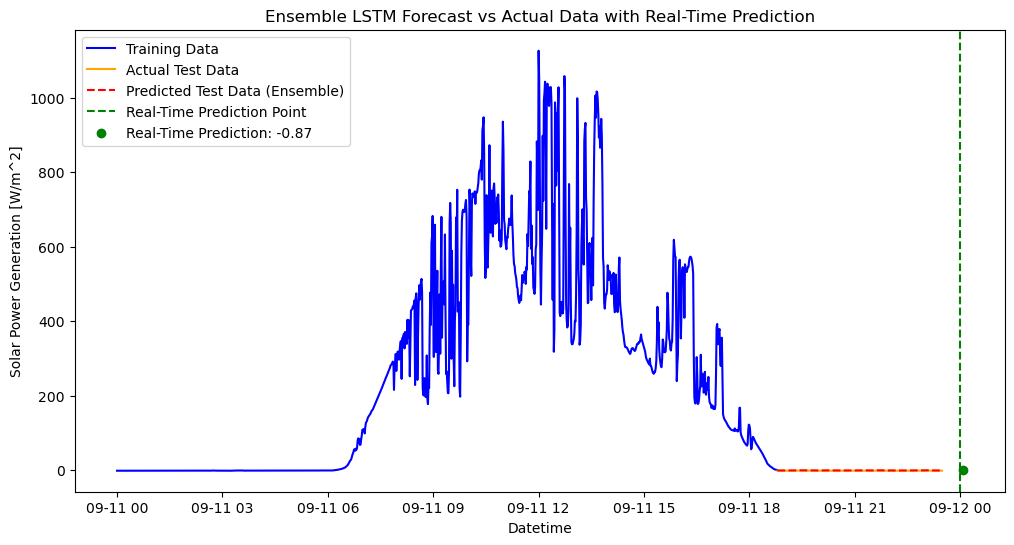

In [1]:
import pickle
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess data
data = pd.read_csv('texas_110924.csv')

# Create DataFrame
df = pd.DataFrame(data)

# Convert DATE to datetime format and CST to time format
df['DATE'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'], format='%m/%d/%Y')
df['CST'] = pd.to_datetime(df['CST'], format='%H:%M').dt.time

# Combine DATE and CST into a single datetime column
df['Datetime'] = df.apply(lambda row: pd.Timestamp.combine(row['DATE'], row['CST']), axis=1)
df.set_index('Datetime', inplace=True)

# Select the column we want and drop missing values
df = df[['Global Horizontal [W/m^2]']].dropna()

# Convert DataFrame to NumPy array for scaling
values = df.values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 5))
scaled_data = scaler.fit_transform(values)

# Create dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Set the time step and split data for training/testing
time_step = 30
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.8) # trained wiht 80% of dataset 
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Function to build and compile an LSTM model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train multiple LSTM models with different configurations
num_models = 3  # Train 3 models as an ensemble
models = []

for i in range(num_models):
    model = build_lstm_model()
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])
    models.append(model)

# Save all trained models in one file using pickle
with open('multiple_models.pkl', 'wb') as f:
    pickle.dump(models, f)

# Save the scaler used for data normalization in the same file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Models and scaler saved successfully!")


# Predict the test set results with each model
predictions = []
for model in models:
    pred = model.predict(X_test)
    predictions.append(pred)

# Combine predictions from multiple models (e.g., using averaging)
predictions = np.array(predictions)  # Shape: (n_models, n_samples, 1)
combined_predictions = np.mean(predictions, axis=0)  # Averaging the predictions across models

# Rescale the predictions back to the original scale
combined_predictions_rescaled = scaler.inverse_transform(combined_predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Function to handle real-time predictions with new data for each model and ensemble
def predict_real_time(new_data):
    new_data_array = np.array(new_data).reshape(-1, 1)
    scaled_new_data = scaler.transform(new_data_array)
    input_data = scaled_new_data[-time_step:].reshape(1, time_step, 1)
    
    model_predictions = []
    for model in models:
        prediction = model.predict(input_data)
        model_predictions.append(prediction)
    
    # Average the predictions of all models for real-time data
    final_prediction = np.mean(model_predictions, axis=0)
    return scaler.inverse_transform(final_prediction)[0][0]

# Simulate real-time data
new_data = df['Global Horizontal [W/m^2]'].tail(time_step).values
next_prediction = predict_real_time(new_data)

# Plot the historical data, predicted test data, and real-time forecast
plt.figure(figsize=(12, 6))

# Plot historical actual data (including training and test data)
plt.plot(df.index[:train_size], df['Global Horizontal [W/m^2]'][:train_size], color='blue', label='Training Data')
plt.plot(df.index[train_size:train_size + len(y_test)], y_test_rescaled, color='orange', label='Actual Test Data')

# Plot predicted test data
plt.plot(df.index[train_size:train_size + len(combined_predictions_rescaled)], combined_predictions_rescaled, color='red', linestyle='--', label='Predicted Test Data (Ensemble)')

# Plot real-time prediction (append to the last index)
plt.axvline(x=df.index[-1], color='green', linestyle='--', label='Real-Time Prediction Point')
plt.scatter(df.index[-1] + pd.Timedelta(minutes=5), next_prediction, color='green', label=f'Real-Time Prediction: {next_prediction:.2f}', zorder=5)

plt.title('Ensemble LSTM Forecast vs Actual Data with Real-Time Prediction')
plt.xlabel('Datetime')
plt.ylabel('Solar Power Generation [W/m^2]')
plt.legend()
plt.show()



In [2]:
models


In [3]:
# Combine predictions from multiple models (e.g., using averaging)
# predictions = np.array(predictions)  # Shape: (n_models, n_samples, 1)
# combined_predictions = np.mean(predictions, axis=0)  # Averaging the predictions across models

predictions


array([[[ 1.87745690e-03],
        [ 1.85729936e-03],
        [ 1.84465945e-03],
        [ 1.83627382e-03],
        [ 1.83068216e-03],
        [ 1.82680413e-03],
        [ 1.82399526e-03],
        [ 1.82138756e-03],
        [ 1.81921199e-03],
        [ 1.81747973e-03],
        [ 1.81613863e-03],
        [ 1.81512535e-03],
        [ 1.81429088e-03],
        [ 1.81350857e-03],
        [ 1.82423741e-03],
        [ 1.82426721e-03],
        [ 1.82111561e-03],
        [ 1.81778148e-03],
        [ 1.81516632e-03],
        [ 1.81342661e-03],
        [ 1.81233883e-03],
        [ 1.81185082e-03],
        [ 1.81161985e-03],
        [ 1.81154534e-03],
        [ 1.81147829e-03],
        [ 1.81137025e-03],
        [ 1.84566155e-03],
        [ 1.87057629e-03],
        [ 1.97859108e-03],
        [ 2.23502517e-03],
        [ 2.42942572e-03],
        [ 2.52601132e-03],
        [ 2.73280963e-03],
        [ 2.86769867e-03],
        [ 2.88251042e-03],
        [ 3.05573829e-03],
        [ 3.22595052e-03],
 

In [12]:
sys. getsizeof(predictions) 

NameError: name 'sys' is not defined

In [13]:
sys. getsizeof(4) 

NameError: name 'sys' is not defined

In [14]:
import sys

In [15]:
sys.getsizeof(predictions) 

3528

In [17]:
sys.getsizeof(models) 

88

In [18]:
# Save the trained model
models.save('trained_models.h5')

AttributeError: 'list' object has no attribute 'save'

In [19]:
models


In [20]:
models.save('hi.h5')

AttributeError: 'list' object has no attribute 'save'

In [21]:
model.save('hi.h5')
